In [2]:
import uproot 
import numpy as np
import coffea
from coffea.nanoaod import NanoEvents
from coffea.nanoaod.methods.leptons import *
from coffea import hist
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter 

Due to the size of these samples this analysis only investigates the 1-5 GeV range. For pt<1GeV the number of matched electrons is too small to investigate.

In [3]:
# events with 10mm displacement
fname_10mm="/uscms/home/ahall/nobackup/public/forTamas/iDM_nanoaod_ctau-10.root"
events_10mm = NanoEvents.from_file(fname_10mm,methods={"ElectronBPark":Electron})

#events with 1mm displacement
fname_1mm="/uscms/home/ahall/nobackup/public/forTamas/iDM_nanoaod.root"
events_1mm = NanoEvents.from_file(fname_1mm,methods={"ElectronBPark":Electron})

We start with a MET and Jet trigger on the event level.

Our requirements for a matched gen particle:
    Electron or positron (+-11)
    Dark photon parent (1000023)
    Come from the main ("hard") interaction instead of a pileup interaction
    Be the first of it's type of particle in the chain to avoid duplicate particles.

For clarity I'm excluding Particle Flow electrons, since they it doesn't produce electrons with pt<5GeV.

When defining unmatched electrons there are two categories to be taken into account:
    1. Fake electrons (corresponds to matched_gen==None)
    2. Real electrons that were produced from a Jet or from a pile up (corresponds to an existing matched_gen, but that matched gen particle does not staisfy our criteria.



In [4]:
# event level MET-Jet cut
def MET_Jet_cut (events): 
    return events [
        (events.MET.pt >120)
        & (events.Jet.pt.max() > 80)
    ]

soft_eles_1mm = MET_Jet_cut(events_1mm).ElectronBPark
soft_eles_10mm = MET_Jet_cut(events_10mm).ElectronBPark

# recquirement for matched gen electrons
# as a cut
def matched_gen_cut (electrons):
    return electrons [
        (abs(electrons.matched_gen.pdgId) == 11) 
               & (electrons.matched_gen.parent.pdgId == 1000023)
               & (electrons.matched_gen.status == 1)
               & (electrons.matched_gen.hasFlags(["fromHardProcess", "isFirstCopy"]))
    ]
# as a mask
def matched_gen_mask (electrons):
    return ((abs(electrons.matched_gen.pdgId) == 11) 
               & (electrons.matched_gen.parent.pdgId == 1000023)
               & (electrons.matched_gen.status == 1) 
               & (electrons.matched_gen.hasFlags(["fromHardProcess", "isFirstCopy"])))

def gen_part_cut (genpart):
    return genpart [
        (abs(genpart.pdgId) == 11) 
               & (genpart.parent.pdgId == 1000023)
               & (genpart.status == 1) 
               & (genpart.hasFlags(["fromHardProcess", "isFirstCopy"]))
    ]

all_gen_eles_1mm = gen_part_cut(MET_Jet_cut(events_1mm).GenPart)
all_gen_eles_10mm = gen_part_cut(MET_Jet_cut(events_10mm).GenPart)

# define matched electrons
matched_eles_1mm = matched_gen_cut(soft_eles_1mm[soft_eles_1mm.isPF==False])
matched_eles_10mm = matched_gen_cut(soft_eles_10mm[soft_eles_10mm.isPF==False])

# defining unmatched electrons
unmatched_eles_1mm = soft_eles_1mm[(~(matched_gen_mask(soft_eles_1mm).fillna(False))) 
                                   & (soft_eles_1mm.isPF == False)]
unmatched_eles_10mm = soft_eles_10mm[(~(matched_gen_mask(soft_eles_10mm).fillna(False))) 
                                   & (soft_eles_10mm.isPF == False)]

In [5]:
def cut_pt(electrons):
    return electrons[
        (electrons.pt<5) 
        & (electrons.pt>1)
    ]
print("The number of matched electrons with 1<pt<5 GeV (cTau=1mm):")
print(len(cut_pt(matched_eles_1mm).flatten()))
print("The number of matched electrons with 1<pt<5 GeV (cTau=10mm):")
print(len(cut_pt(matched_eles_10mm).flatten()))

The number of matched electrons with 1<pt<5 GeV (cTau=1mm):
434
The number of matched electrons with 1<pt<5 GeV (cTau=10mm):
266


Initially the two samples were investigated separately and different cuts were proposed for both samples separately. A combined ID is proposed, taking into account the perfomance of both the 1mm and 10mm samples.

In [6]:
def cut_1mm(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.ip3d < 0.5)
        & (electrons.sip3d < 100)
        & (electrons.fBrem > -1.9)
        & (electrons.sip3d > 0.2)
        & (electrons.mvaId > 1.3)
        & (abs(electrons.dz) < 0.25)
         & (abs(electrons.dxy) < 0.3)
         & (electrons.ptBiased > 0.5)
    ]
def cut_10mm(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.ip3d < 2.5)
        & (electrons.ip3d > 0.02)
        & (electrons.fBrem > -1.9)
        & (electrons.sip3d < 160)
        & (electrons.sip3d > 0.2)
        & (electrons.mvaId > 1.2)
        & (abs(electrons.dz) < 2)
         & (abs(electrons.dxy) < 1)
         & (electrons.ptBiased > 0.5)
    ]


# The ID below was optimized to work with both samples (cTau=1mm and cTau==10mm)
def cut_combined (electrons):
    return electrons[
        (electrons.pt>1) & (electrons.pt<5)
        & (electrons.mvaId > 1.3)
        & (electrons.ptBiased > 0.5)
        & (electrons.fBrem > -1.9)
        & (electrons.sip3d > 0.2)
        & (electrons.sip3d <110)
        & (electrons.ip3d < 2)
        & (abs(electrons.dxy) < 1) 
        & (abs(electrons.dz) < 1.8)
        & (electrons.ip3d > 0.01) 
    ]
print("Number of matched electrons passing cut_1mm for cTau=1mm:")
print(len(cut_1mm(matched_eles_1mm).flatten()))
print("Number of matched electrons passing cut_10mm for cTau=10mm:")
print(len(cut_10mm(matched_eles_10mm).flatten()))
print("Number of matched electrons passing cut_combined for cTau=1mm:")
print(len(cut_combined(matched_eles_1mm).flatten()))
print("Number of matched electrons passing cut_combined for cTau=10mm:")
print(len(cut_combined(matched_eles_10mm).flatten()))

Number of matched electrons passing cut_1mm for cTau=1mm:
272
Number of matched electrons passing cut_10mm for cTau=10mm:
167
Number of matched electrons passing cut_combined for cTau=1mm:
280
Number of matched electrons passing cut_combined for cTau=10mm:
158


In [7]:
#
# Note that in the function below I count all non-matched electrons as fakes
#
import operator
# calculates the number of fakes per event
# parameter "electrons": jagged array of events
# paramter "good_cut": cut on electrons
# parameter "matched_cut": matching cut
# parameter "pf_mask": from/not from Particle Flow 
# output: returns a list containing the number of fakes per event
def numfakes(electrons, good_cut, matched_cut, pf_mask):
    x=[]
    for i in good_cut(electrons[pf_mask]):
        x.append(len(i))
    y=[]
    for i in good_cut(matched_cut(electrons[pf_mask])):
        y.append(len(i))
    return list(map(operator.sub, x, y))

Ideally we are aiming to keep the number of fake electrons per event under 1, since in our model we expect to see two electrons.

The avg. number of fakes per event for cTau=1mm (with cut_1mm):
0.8955431754874652
The avg. number of fakes per event for cTau=1mm (with cut_combined):
0.9965181058495822
Then avg. number of fakes per event for cTau=1mm (with cut_pt):
40.98398328690808


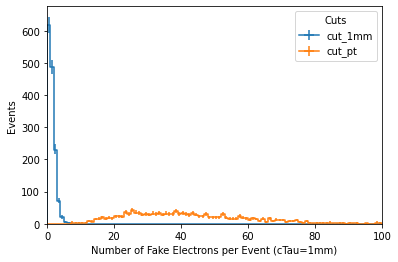

In [8]:
# a plot of the number of fakes per event for cTau=1mm
histo_numfakes_1mm= hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("numfakes", "Number of Fake Electrons per Event (cTau=1mm)", 100, 0, 100),
        )

#histo_numfakes.fill(cuts="no_cut", numfakes = np.array(numfakes(soft_eles, cuttest, matched_mask, (soft_eles.isPF == False))))
histo_numfakes_1mm.fill(cuts="cut_pt", numfakes = np.array(numfakes(soft_eles_1mm, cut_pt, matched_gen_cut, (soft_eles_1mm.isPF == False))))
histo_numfakes_1mm.fill(cuts="cut_1mm", numfakes = np.array(numfakes(soft_eles_1mm, cut_1mm, matched_gen_cut, (soft_eles_1mm.isPF == False))))

#
# Note that when calculating the average number of fakes per event I'm also taking into account
# events with zero truth and zero fake electrons.
#
print("The avg. number of fakes per event for cTau=1mm (with cut_1mm):")
print(sum(numfakes(soft_eles_1mm, cut_1mm, matched_gen_cut, (soft_eles_1mm.isPF == False)))/len(numfakes(soft_eles_1mm, cut_1mm, matched_gen_cut, (soft_eles_1mm.isPF == False))))
print("The avg. number of fakes per event for cTau=1mm (with cut_combined):")
print(sum(numfakes(soft_eles_1mm, cut_combined, matched_gen_cut, (soft_eles_1mm.isPF == False)))/len(numfakes(soft_eles_1mm, cut_combined, matched_gen_cut, (soft_eles_1mm.isPF == False))))
print("Then avg. number of fakes per event for cTau=1mm (with cut_pt):")
print(sum(numfakes(soft_eles_1mm, cut_pt, matched_gen_cut, (soft_eles_1mm.isPF == False)))/len(numfakes(soft_eles_1mm, cut_pt, matched_gen_cut, (soft_eles_1mm.isPF == False))))
hist.plot1d(histo_numfakes_1mm)

The avg. number of fakes per event for cTau=10mm (with cut_10mm):
0.8838451268357811
The avg. number of fakes per event for cTau=10mm (with cut_combined):
0.8491321762349799
Then avg. number of fakes per event for cTau=10mm (with cut_pt):
41.649532710280376


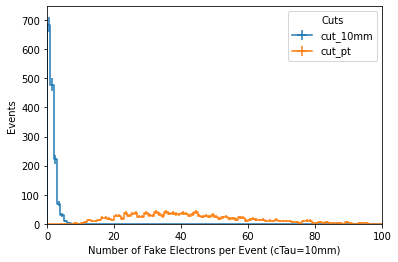

In [9]:
# a plot of the number of fakes per event for cTau=1mm
histo_numfakes_10mm= hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("numfakes", "Number of Fake Electrons per Event (cTau=10mm)", 100, 0, 100),
        )

#histo_numfakes.fill(cuts="no_cut", numfakes = np.array(numfakes(soft_eles, cuttest, matched_mask, (soft_eles.isPF == False))))
histo_numfakes_10mm.fill(cuts="cut_pt", numfakes = np.array(numfakes(soft_eles_10mm, cut_pt, matched_gen_cut, (soft_eles_10mm.isPF == False))))
histo_numfakes_10mm.fill(cuts="cut_10mm", numfakes = np.array(numfakes(soft_eles_10mm, cut_10mm, matched_gen_cut, (soft_eles_10mm.isPF == False))))

#
# Note that when calculating the average number of fakes per event I'm also taking into account
# events with zero truth and fake electrons.
#
print("The avg. number of fakes per event for cTau=10mm (with cut_10mm):")
print(sum(numfakes(soft_eles_10mm, cut_10mm, matched_gen_cut, (soft_eles_10mm.isPF == False)))/len(numfakes(soft_eles_10mm, cut_10mm, matched_gen_cut, (soft_eles_10mm.isPF == False))))
print("The avg. number of fakes per event for cTau=10mm (with cut_combined):")
print(sum(numfakes(soft_eles_10mm, cut_combined, matched_gen_cut, (soft_eles_10mm.isPF == False)))/len(numfakes(soft_eles_10mm, cut_combined, matched_gen_cut, (soft_eles_10mm.isPF == False))))
print("Then avg. number of fakes per event for cTau=10mm (with cut_pt):")
print(sum(numfakes(soft_eles_10mm, cut_pt, matched_gen_cut, (soft_eles_10mm.isPF == False)))/len(numfakes(soft_eles_10mm, cut_pt, matched_gen_cut, (soft_eles_10mm.isPF == False))))
hist.plot1d(histo_numfakes_10mm)

Resolution curves were created with respect to several variables. However, it was found that the one with respect to pt is the best indicator of how "close" our reco electrons is to the corresponding gen particles.

(-0.5, 0.5)

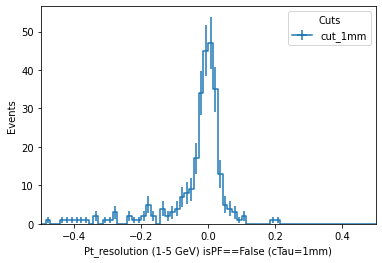

In [10]:
# pt resolution curve for 1-5 GeV cTau=1mm

flat_eles_1mm = cut_1mm(matched_eles_1mm).flatten()
pt_reso_cut_1mm = (flat_eles_1mm.pt - flat_eles_1mm.matched_gen.pt) / (flat_eles_1mm.matched_gen.pt)

histo_pt_reso_1mm = hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("pt_reso", "Pt_resolution (1-5 GeV) isPF==False (cTau=1mm)", 70, -0.5, 0.5),
        )
histo_pt_reso_1mm.fill(cuts = "cut_1mm", pt_reso = np.array(pt_reso_cut_1mm))

ax_pt_reso_1mm = hist.plot1d(histo_pt_reso_1mm, overflow = "all")
ax_pt_reso_1mm.set_xlim(right=0.5, left=-0.5)


(-0.5, 0.5)

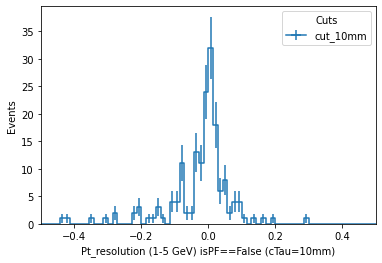

In [11]:
# pt resolution curve for 1-5 GeV cTau=10mm

flat_eles_10mm = cut_10mm(matched_eles_10mm).flatten()
pt_reso_cut_10mm = (flat_eles_10mm.pt - flat_eles_10mm.matched_gen.pt) / (flat_eles_10mm.matched_gen.pt)

histo_pt_reso_10mm = hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("pt_reso", "Pt_resolution (1-5 GeV) isPF==False (cTau=10mm)", 70, -0.5, 0.5),
        )
histo_pt_reso_10mm.fill(cuts = "cut_10mm", pt_reso = np.array(pt_reso_cut_10mm))

ax_pt_reso_10mm = hist.plot1d(histo_pt_reso_10mm, overflow = "all")
ax_pt_reso_10mm.set_xlim(right=0.5, left=-0.5)

Efficiency curves were investigated with repect to several variables, and similarly to resolution curves, the efficiency with respect to pt was found to be the best measure of the preformance of our ID.

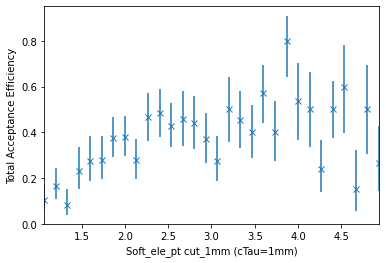

In [12]:
#----------------------------------------------------------------------------
# pt efficiency curves
#----------------------------------------------------------------------------
histo_all_1mm = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt cTau=1mm", 30, 1, 5),
        )

histo_all_1mm.fill(variables="denominator", soft_ele = cut_pt(matched_eles_1mm).pt.flatten())

#total acceptance efficiency cruve for cut_1mm
histo_all_genele_1mm = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Gen_ele_pt cTau=1mm", 30, 1, 5),
        )
histo_eff_cut_1mm = hist.Hist(
            "Total Acceptance Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt cut_1mm (cTau=1mm)", 30, 1, 5),
        )
histo_eff_cut_1mm.fill(variables="looseMVA", soft_ele = cut_1mm(matched_eles_1mm).pt.flatten())
histo_all_genele_1mm.fill(variables="denominator", soft_ele = cut_pt(all_gen_eles_1mm).pt.flatten())

%matplotlib inline
hist.plotratio(num=histo_eff_cut_1mm.integrate("variables"), denom=histo_all_genele_1mm.integrate("variables"), error_opts={"marker": "x"})

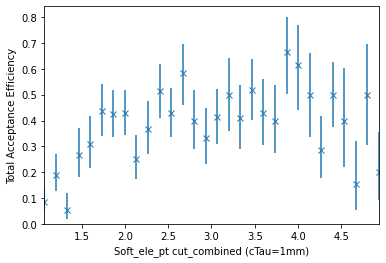

In [13]:
#total acceptance efficiency cruve for combined cut (cTau=1mm)
histo_eff_cut_combined_1mm = hist.Hist(
            "Total Acceptance Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt cut_combined (cTau=1mm)", 30, 1, 5),
        )
histo_eff_cut_combined_1mm.fill(variables="looseMVA", soft_ele = cut_combined(matched_eles_1mm).pt.flatten())

%matplotlib inline
hist.plotratio(num=histo_eff_cut_combined_1mm.integrate("variables"), denom=histo_all_genele_1mm.integrate("variables"), error_opts={"marker": "x"})

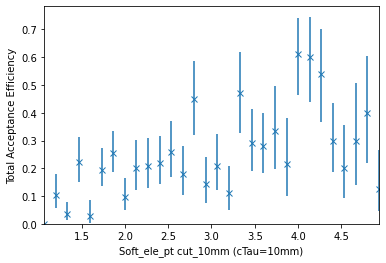

In [14]:
#----------------------------------------------------------------------------
# pt efficiency curves
#----------------------------------------------------------------------------
histo_all_10mm = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt cTau=10mm", 30, 1, 5),
        )

histo_all_10mm.fill(variables="denominator", soft_ele = cut_pt(matched_eles_10mm).pt.flatten())

#total acceptance efficiency cruve
histo_all_genele_10mm = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Gen_ele_pt cTau=10mm", 30, 1, 5),
        )
histo_eff_cut_10mm = hist.Hist(
            "Total Acceptance Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt cut_10mm (cTau=10mm)", 30, 1, 5),
        )
histo_eff_cut_10mm.fill(variables="looseMVA", soft_ele = cut_10mm(matched_eles_10mm).pt.flatten())
histo_all_genele_10mm.fill(variables="denominator", soft_ele = cut_pt(all_gen_eles_10mm).pt.flatten())

%matplotlib inline
hist.plotratio(num=histo_eff_cut_10mm.integrate("variables"), denom=histo_all_genele_10mm.integrate("variables"), error_opts={"marker": "x"})

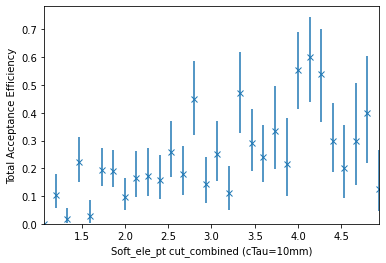

In [15]:
histo_eff_cut_combined_10mm = hist.Hist(
            "Total Acceptance Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt cut_combined (cTau=10mm)", 30, 1, 5),
        )
histo_eff_cut_combined_10mm.fill(variables="looseMVA", soft_ele = cut_combined(matched_eles_10mm).pt.flatten())

%matplotlib inline
hist.plotratio(num=histo_eff_cut_combined_10mm.integrate("variables"), denom=histo_all_genele_10mm.integrate("variables"), error_opts={"marker": "x"})

ROC plots are defined as:
                            SE: (Matched electrons with cut) / (All matched electrons)
                            BE: (Unamtched electrons with cut) / (All unmatched electrons)

I found ROC curves not very useful when determining the ID and it's performance, since first of all when coming up with an ID one would have to take into account the order in which cuts are made in order to utilize ROC curves. Second of all, cuts on some variables like "trkRelIso" do considerably improve the shape of the ROC curve, but trkRelIso is useless in coming up with an ID, because too many matched electrons would have to be sacrificed to reduce the number of fakes. I believe that the combination of efficiency curves and the average number of fakes per event is a better alternative to ROC plots.
Below are examples for a ROC plots, comparing ROC curves for samples with and without an ID. Out of all the variables investigated ROC plots with respect to mvaId were found to be the best looking. This is because mvaId succeeds the most in differentiating matched and unmatched electrons.

In [31]:
#----------------------------------------------------------------------------
# function to create ROC plots 
#----------------------------------------------------------------------------
def makeroc(sig, bkg, binning, direction=1):
    '''Given a signal and background discriminant array, along with a binning,
    compute the ROC curve by integrating discriminant histograms along a direction:
        1: cut < value
        -1: cut >= value
    Returns a tuple of (signal efficiency, background efficiency)'''
    sighist, _ = np.histogram(sig, bins=binning)
    bkghist, _ = np.histogram(bkg, bins=binning)
    # numpy histogram will ignore values out of range of our binning (overflow)
    # so add the overflow values that would pass given our cut direction
    if direction == 1:
        sighist[0] += sum(sig < binning[0])
        bkghist[0] += sum(bkg < binning[0])
    elif direction == -1:
        sighist[-1] += sum(sig > binning[-1])
        bkghist[-1] += sum(bkg > binning[-1])
    else:
        raise ValueError("Invalid direction")
    sigpass = (np.cumsum(sighist[::direction]) / len(sig))[::direction]
    bkgpass = (np.cumsum(bkghist[::direction]) / len(bkg))[::direction]
    return (sigpass, bkgpass)

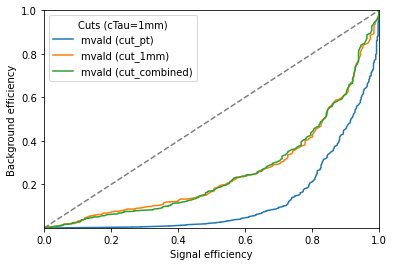

In [34]:
# ROC plots with respect to mvaId for cTau=1mm

roc_mva_1mm = makeroc(
    sig=cut_pt(matched_eles_1mm).mvaId.flatten(),
    bkg=cut_pt(unmatched_eles_1mm).mvaId.flatten(),
    binning=np.linspace(-10, 10, 1000),
    direction=-1,
)

roc_mva_cut1mm = makeroc(
    sig=cut_1mm(matched_eles_1mm).mvaId.flatten(),
    bkg=cut_1mm(unmatched_eles_1mm).mvaId.flatten(),
    binning=np.linspace(-10, 10, 1000),
    direction=-1,
)

roc_mva_1mm_combined = makeroc(
    sig=cut_combined(matched_eles_1mm).mvaId.flatten(),
    bkg=cut_combined(unmatched_eles_1mm).mvaId.flatten(),
    binning=np.linspace(-10, 10, 1000),
    direction=-1,
)

fig_1mm, ax_1mm = plt.subplots()
ax_1mm.plot(*roc_mva_1mm, label=r"mvaId (cut_pt)")
ax_1mm.plot(*roc_mva_cut1mm, label=r"mvaId (cut_1mm)")
ax_1mm.plot(*roc_mva_1mm_combined, label=r"mvaId (cut_combined)")
diag = np.linspace(0, 1, 100)
ax_1mm.plot(diag, diag, color='grey', linestyle='--')
ax_1mm.set_xlabel("Signal efficiency")
ax_1mm.set_ylabel("Background efficiency")
ax_1mm.set_xlim(0, 1)
ax_1mm.set_ylim(1e-3, 1)
ax_1mm.legend(title=r'Cuts (cTau=1mm)')

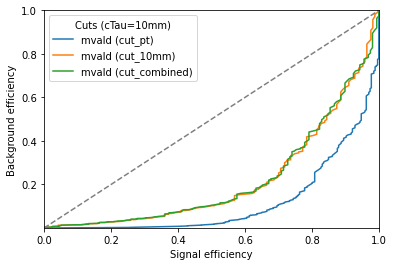

In [35]:
# ROC plots with respect to mvaId for cTau=10mm

roc_mva_10mm = makeroc(
    sig=cut_pt(matched_eles_10mm).mvaId.flatten(),
    bkg=cut_pt(unmatched_eles_10mm).mvaId.flatten(),
    binning=np.linspace(-10, 10, 1000),
    direction=-1,
)

roc_mva_cut10mm = makeroc(
    sig=cut_10mm(matched_eles_10mm).mvaId.flatten(),
    bkg=cut_10mm(unmatched_eles_10mm).mvaId.flatten(),
    binning=np.linspace(-10, 10, 1000),
    direction=-1,
)

roc_mva_10mm_combined = makeroc(
    sig=cut_combined(matched_eles_10mm).mvaId.flatten(),
    bkg=cut_combined(unmatched_eles_10mm).mvaId.flatten(),
    binning=np.linspace(-10, 10, 1000),
    direction=-1,
)

fig_10mm, ax_10mm = plt.subplots()
ax_10mm.plot(*roc_mva_10mm, label=r"mvaId (cut_pt)")
ax_10mm.plot(*roc_mva_cut10mm, label=r"mvaId (cut_10mm)")
ax_10mm.plot(*roc_mva_10mm_combined, label=r"mvaId (cut_combined)")
ax_10mm.plot(diag, diag, color='grey', linestyle='--')
ax_10mm.set_xlabel("Signal efficiency")
ax_10mm.set_ylabel("Background efficiency")
ax_10mm.set_xlim(0, 1)
ax_10mm.set_ylim(1e-3, 1)
ax_10mm.legend(title=r'Cuts (cTau=10mm)')